In [21]:
# Header for the notebook
from datetime import datetime
from IPython.display import display, Markdown

# Get the current date
title = "Circular_Task_Project"
current_date = datetime.now().strftime("%d %B %Y, %H:%M:%S")
authors = "Hugo (and Copilot)"

# Insert the date into the notebook
display(Markdown(f"# {title}"))
display(Markdown(f"{current_date}"))
display(Markdown(f"by {authors}"))

# Circular_Task_Project

28 November 2025, 11:01:53

by Hugo (and Copilot)

In [22]:
# Set up the environment without pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches 

# 1/ Load the data
FILE = "data/001MoDe_R1.csv"
# Load full dataset
full_data = np.genfromtxt(FILE, delimiter=';', skip_header=3, names=True)
# Keep only the useful columns
blank = full_data[['timestamp', 'mouseX', 'mouseY', 'mouseInTarget']]
# Center coordinates reference
CENTER_X = 552
CENTER_Y = 330

timestamp = np.array(blank['timestamp'], dtype=np.int64)

print("The first 5 lines of the dataset:")
print(blank[:5])

print("\n--- 5 first Timestamps ---")
print(timestamp[:5])

# Verification of X and Y coordinates
# Extract the columns as you did for the timestamp
x_vals = np.array(blank['mouseX'])
y_vals = np.array(blank['mouseY'])

print("\n--- 5 first X and Y ---")
# Loop to display them neatly side by side
for i in range(5):
    print(f"Line {i}: X={x_vals[i]}, Y={y_vals[i]}")

# Small safety check (see if there are any NaNs)
if np.isnan(timestamp[0]):
    print("\n⚠️ WARNING: Timestamps are 'nan'. The CSV file format might be problematic (decimal commas?).")
else:
    print("\n✅ The data seems to be loaded correctly.")

The first 5 lines of the dataset:
[(1.61677671e+12, 501., 554., 1.) (1.61677671e+12, 487., 551., 1.)
 (1.61677671e+12, 484., 550., 1.) (1.61677671e+12, 481., 549., 1.)
 (1.61677671e+12, 478., 548., 1.)]

--- 5 first Timestamps ---
[1616776712329 1616776712351 1616776712356 1616776712359 1616776712366]

--- 5 first X and Y ---
Line 0: X=501.0, Y=554.0
Line 1: X=487.0, Y=551.0
Line 2: X=484.0, Y=550.0
Line 3: X=481.0, Y=549.0
Line 4: X=478.0, Y=548.0

✅ The data seems to be loaded correctly.


## My role in this Group Project is to recreate the Circle Graph for all the records

### Let's begin by recreating the 5 records before plotting the final accumulated record (the raw trajectory data). 

--- Automatic analysis of: data/001MoDe_R1.csv ---
✅ 5 records detected automatically.
Generating plot for Record 0...


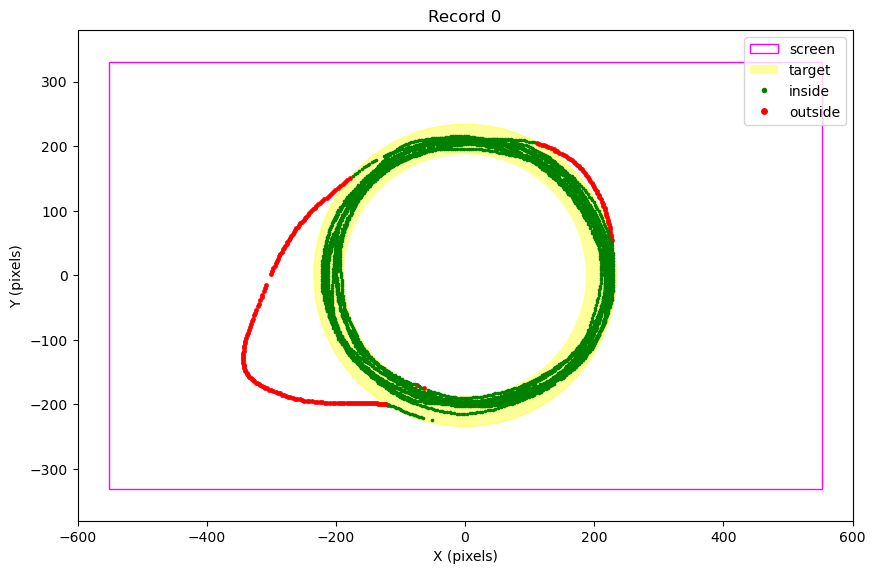

Generating plot for Record 1...


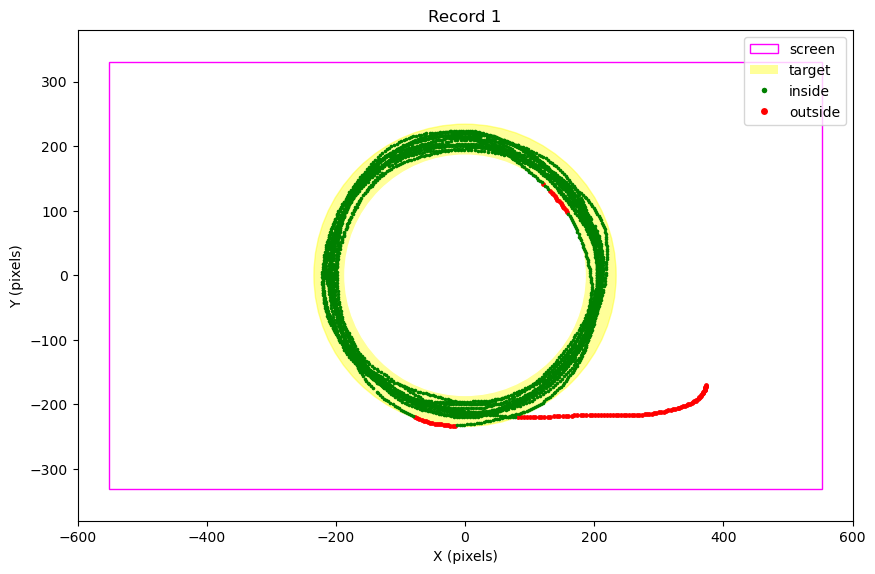

Generating plot for Record 2...


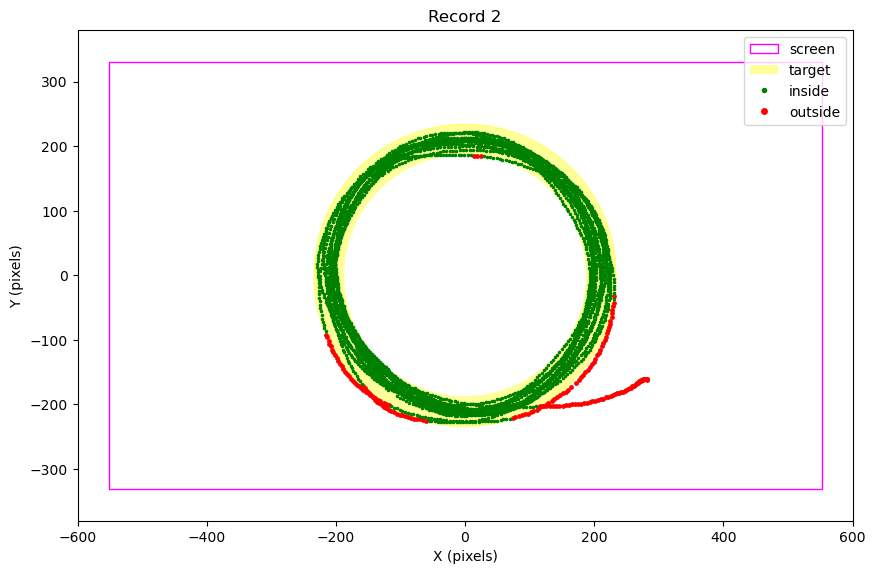

Generating plot for Record 3...


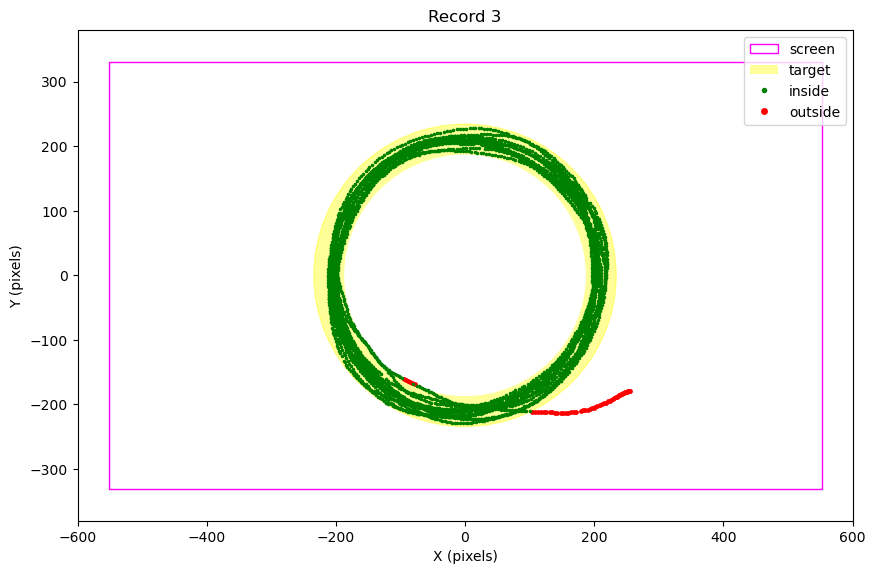

Generating plot for Record 4...


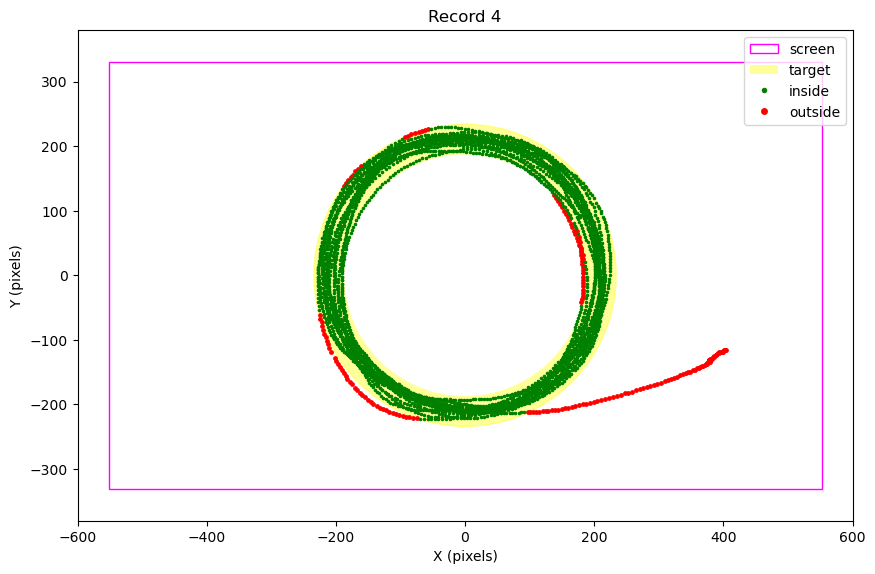

Done.


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D

# =============================================================================
# 1. CONFIGURATION
# =============================================================================
filename = "data/001MoDe_R1.csv"

# =============================================================================
# 2. DATA LOADING & AUTOMATIC SEGMENTATION
# =============================================================================
print(f"--- Automatic analysis of: {filename} ---")

# A. Parse parameters from header
params = {
    'centerX': 552, 'centerY': 330, 
    'externalRadius': 250, 'internalRadius': 170, 'cursorRadius': 16,
    'screenWidth': 1104, 'screenHeight': 661
}
try:
    with open(filename, 'r') as f:
        header = f.readline().strip()
    for part in header.split(';'):
        if ' ' in part:
            k, v = part.strip().split(' ', 1)
            try: params[k] = float(v)
            except: pass
except: pass

# B. Raw Data Reading (Robust method)
raw_data = []
try:
    with open(filename, 'r') as f:
        # Skip headers (3 lines)
        lines = f.readlines()[3:]
        
    for line in lines:
        if not line.strip(): continue
        # Handle separators ; or ,
        sep = ';' if ';' in line else ','
        vals = line.strip().split(sep)
        
        try:
            # Parse Timestamp, X, Y, InTarget (cols 0, 1, 2, 3)
            # Replace comma with dot just in case
            t = float(vals[0].replace(',', '.'))
            x = float(vals[1].replace(',', '.'))
            y = float(vals[2].replace(',', '.'))
            it = float(vals[3].replace(',', '.'))
            raw_data.append([t, x, y, it])
        except: continue

except Exception as e:
    print(f"Read error: {e}")

data = np.array(raw_data)

# C. Automatic Detection of Records
# We filter out invalid points (0,0) first
# Then we look for large time gaps (> 1000ms) to identify separate records
valid_points = data[(data[:, 1] != 0) | (data[:, 2] != 0)] 

timestamps = valid_points[:, 0]
# Find indices where time jump > 1 sec
jumps = np.where(np.diff(timestamps) > 1000)[0] + 1
boundaries = [0] + list(jumps) + [len(valid_points)]

records = []
for i in range(len(boundaries)-1):
    start = boundaries[i]
    end = boundaries[i+1]
    # Keep only sequences with enough points (noise filtering)
    if end - start > 50:
        records.append(valid_points[start:end])

print(f"✅ {len(records)} records detected automatically.")

# =============================================================================
# 3. PLOT GENERATION LOOP
# =============================================================================

# Common visual settings
cx, cy = params.get('centerX', 0), params.get('centerY', 0)
sw, sh = params.get('screenWidth', 1104), params.get('screenHeight', 661)
r_ext = params.get('externalRadius', 250) - params.get('cursorRadius', 16)
r_int = params.get('internalRadius', 170) + params.get('cursorRadius', 16)

# Loop through each detected record
# Enumeration starts at 0 (Record 0, Record 1...)
for i, rec_data in enumerate(records):
    
    print(f"Generating plot for Record {i}...")
    
    # Data preparation
    ts = rec_data[:, 0]
    x = rec_data[:, 1] - cx
    y = -(rec_data[:, 2] - cy) # Invert Y for screen coordinates
    target = rec_data[:, 3]
    
    # Split Valid (Green) / Invalid (Red)
    mask_ok = (target == 1)
    x_ok, y_ok = x[mask_ok], y[mask_ok]
    x_ko, y_ko = x[~mask_ok], y[~mask_ok]
    
    # --- PLOTTING ---
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # 1. Screen (Pink Outline)
    rect = patches.Rectangle((-sw/2, -sh/2), sw, sh, fill=False, edgecolor='#FF00FF', linewidth=1, zorder=1)
    ax.add_patch(rect)
    
    # 2. Target (Yellow Background)
    ax.add_patch(plt.Circle((0,0), r_ext, color='yellow', alpha=0.4, zorder=0))
    ax.add_patch(plt.Circle((0,0), r_int, color='white', zorder=0))
    
    # 3. Points
    if len(x_ko) > 0: ax.scatter(x_ko, y_ko, c='red', s=6, zorder=2)
    if len(x_ok) > 0: ax.scatter(x_ok, y_ok, c='green', s=2.5, zorder=3)
    
    # 4. Formatting
    ax.set_xlim(-600, 600)
    ax.set_ylim(-380, 380)
    ax.set_yticks(np.arange(-300, 301, 100))
    ax.set_aspect('equal')
    
    # Title and Labels in English
    ax.set_title(f"Record {i}")
    ax.set_xlabel("X (pixels)")
    ax.set_ylabel("Y (pixels)")
    
    # Legend in English
    legend_elements = [
        patches.Patch(facecolor='none', edgecolor='#FF00FF', label='screen'),
        patches.Patch(facecolor='yellow', alpha=0.4, label='target'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=5, label='inside'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=6, label='outside')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.show() 

print("Done.")